In [394]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations
from umap import umap_ as UMAP
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

1. Exploratory Data Analysis

In [395]:
# Load train and test datasets
train_data = pd.read_csv('./data/bbc_news_train.csv')
test_data = pd.read_csv('./data/bbc_news_test.csv')

In [396]:
# Display the first 5 rows of the training data
train_data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [397]:
# Display the first 5 rows of the test data
test_data.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [398]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [399]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


In [400]:
# Create numerical labels for the categories. This is for measuring metrics in unsupervised learning later
train_data['category_id'] = train_data['Category'].factorize()[0]
train_data.head()

,ArticleId,Text,Category,category_id
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


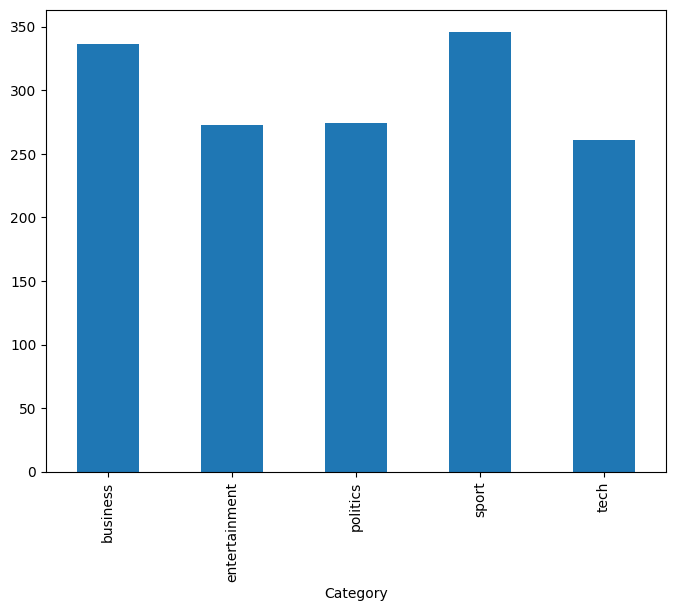

In [401]:
fig = plt.figure(figsize=(8,6))
train_data.groupby('Category').category_id.count().plot.bar(ylim=0)
plt.show()

In [402]:
# Check for missing values
missing_texts = train_data['Text'].isnull().sum()
missing_labels = train_data['Category'].isnull().sum()

print(f'Number of missing texts: {missing_texts}')
print(f'Number of missing labels: {missing_labels}')

Number of missing texts: 0
Number of missing labels: 0


In [403]:
# Checking for duplicate entries
duplicate_texts = train_data['Text'].duplicated().sum()

print(f'Number of duplicate texts: {duplicate_texts}')

Number of duplicate texts: 50


In [404]:
# Drop the duplicates
train_data = train_data.drop_duplicates(subset=['Text'])

# Print info after dropping duplicates to check row counts
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 0 to 1489
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ArticleId    1440 non-null   int64 
 1   Text         1440 non-null   object
 2   Category     1440 non-null   object
 3   category_id  1440 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 56.2+ KB


EDA Findings and Summary
1. The training dataset has 1490 rows and 3 columns. It has "ArticleId" (int type)", "Text" (object type), and "Category" (object type).
2. The test dataset has 735 rows and 2 columns. It has "ArticleId" (int type) and "Text" (object type).
3. There are no missing values; however, there were 50 duplicate text rows, so they were droppped and the training data set was updated to 1440 rows.
4. There are 5 unique categories in the dataset (Business, Entertainment, Politics, Sport, and Tech).
5. Business and Sport have the highest distribution, while the remaining have about the same.

2. Preprocessing and TF-IDF of Training Data

Technique: Term Frequency-Inverse Document Frequency (TF-IDF)

We will be using this TF-IDF to process raw text into vectors or numbers. The TF-IDF represents the importance of words to a document in a corpus or a collection of documents. The forumla is:

TF-IDF (t, d, D) = TF(t,d) x IDF(t,D), where:
* t = term or word
* d = document
* D = corpus
* TF = term frequency in a document
* IDF = inverse document frequency of term in the corpus

Let's have a couple examples to illustrate the process:
* Doc 1: "I like to eat apples."
* Doc 2: "I like to eat oranges."

Step 1: 
* TF('apples', Doc 1) = 1 / 5 = 0.20
* TF('apples', Doc 2) = 0

Step 2:
* IDF('apples') = log(2/1) = 0.693 (This is calculated by taking the log of the total number of document divided by the number of document that contains the word)

Step 3:
* TF-IDF score for Document 1: 0.20 x 0.693 = 0.139
* TF-IDF score for Document 2: 0 x 0.693 = 0

The results indicate that 'apples' has much more significance in Document 1 than it is in Document 2.

In [405]:
# Note: by using different parameters, we'll be able to get different matrix sizes
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
vec_mat = vectorizer.fit_transform(train_data.Text)
features = vectorizer.get_feature_names_out()

# convert to pandas dataframe
df = pd.DataFrame(vec_mat.toarray(), columns=features)
print(features)
print('matrix size: ', df.shape)

['00' '000' '000m' ... 'zooms' 'zurich' 'zvonareva']
matrix size:  (1440, 13752)


In [406]:
df.head()

,00,000,000m,000th,007,01,0100,0130,028,03,...,zoe,zola,zombie,zombies,zone,zones,zoom,zooms,zurich,zvonareva
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.024543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.019484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [407]:
# We can utilize UMAP to plot (reference: https://umap-learn.readthedocs.io/en/latest/document_embedding.html)
embedding = UMAP.UMAP(metric='hellinger', n_neighbors=5, random_state=0, n_jobs=1).fit_transform(vec_mat)

(-3.4292433857917786,
 16.129050314426422,
 -1.618888944387436,
 21.273084372282028)

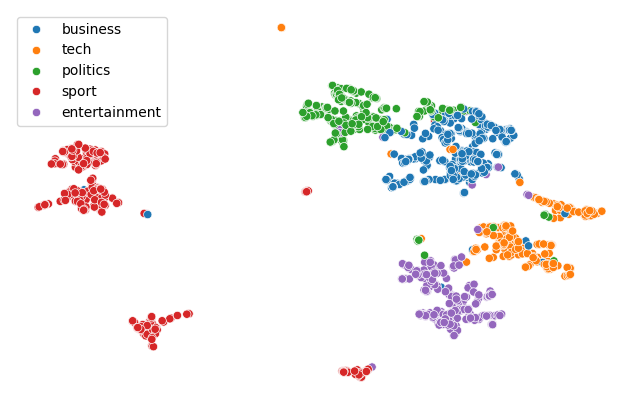

In [408]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=train_data.Category.tolist())
plt.axis('off')

From the graph, you can see we've reduced the large number of dimensionality to just 2D. We can also see that business and politics are closely together, tech and entertainment are close, and sport is kind of just in its own area.

3. Unsupervised Learning

Since the dataset that we're dealing with do not contain negative entries, I think it's best that we use the non-negtaive matrix factorization technique, as known as "Sklearn Non-Negative Matrix Factorization (NMF)". In this section, we will be using several different parameters of NMF to see which is better for us.

In [409]:
nmf = NMF(n_components=5, init='nndsvda', beta_loss='frobenius', solver='cd', max_iter=200).fit(vec_mat)
W = nmf.transform(vec_mat)
H = nmf.components_

In [410]:
def plot_top_words(H, features):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(H):
        top_features_ind = topic.argsort()[-20:]
        top_features = features[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

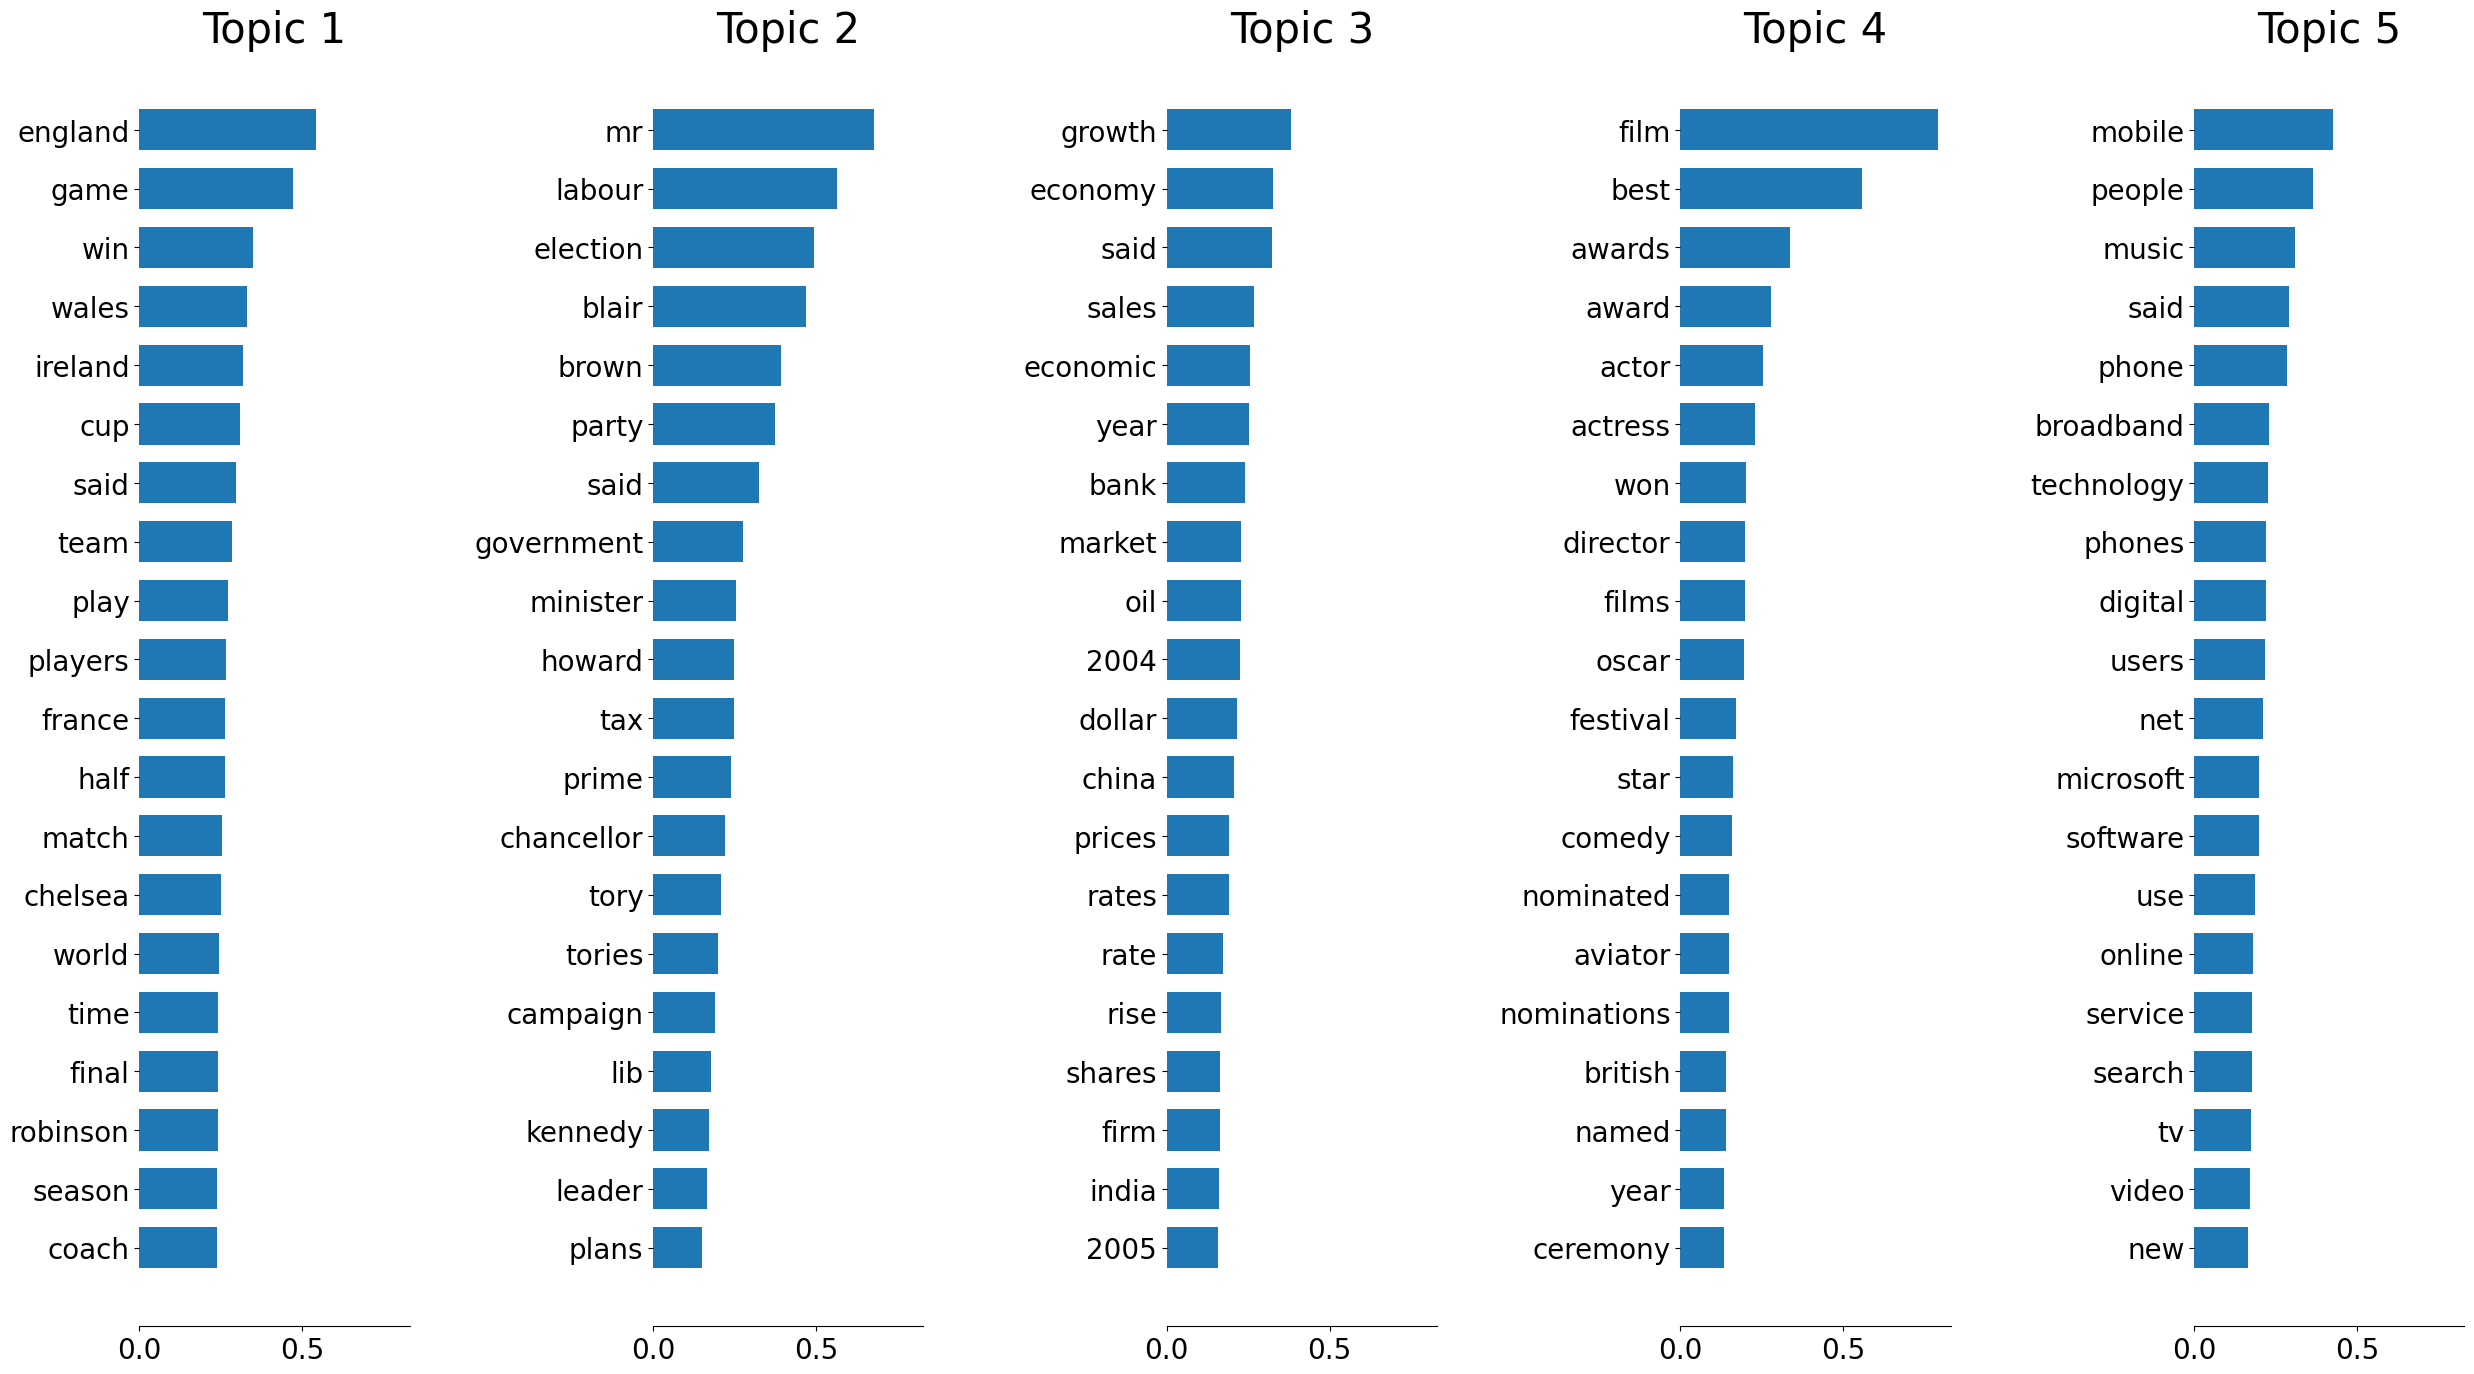

In [411]:
plot_top_words(H, features)

From the graph, we can see the top 20 words associated with each topic. Additionally, we can deduce what categories they belong to by glancing over the top words for each topic. topic 1 being sport, topic 2 being politic, etc.

In [412]:
test = pd.DataFrame(W)
print(test.shape)

(1440, 5)


In [413]:
# Predict category based on Text
train_predictions = W.argmax(axis=1)
print(train_predictions)

[2 2 2 ... 2 4 4]


In [414]:
# Encoding categories
topics_to_str = {0:'sport', 1:'politics', 2:'business', 3:'entertainment', 4:'tech'}
train_prediction_labels = []
for item in train_predictions:
    train_prediction_labels.append(topics_to_str[item])

In [415]:
train_acc = accuracy_score(train_data['Category'], train_prediction_labels)
train_acc = round(train_acc, 4)
print('Training accuracy for Frobenius model is: ', train_acc)

Training accuracy for Frobenius model is:  0.9104


We will try using another parameter called Kullback-Leibler to see if it's better than Frobenius

In [416]:
nmf2 = NMF(n_components=5, init='nndsvda', beta_loss='kullback-leibler', solver='mu', max_iter=200).fit(vec_mat)
W2 = nmf2.transform(vec_mat)
H2 = nmf2.components_

# get the predictions
train_predictions_2 = W2.argmax(axis=1)

train_prediction_labels_2 = [topics_to_str[item] for item in train_predictions_2]

# calculate the accuracy
train_acc_2 = round(accuracy_score(train_data['Category'], train_prediction_labels_2), 4)
print('Training accuracy for Kullback-Leibler model is: ', train_acc_2)

Training accuracy for Kullback-Leibler model is:  0.959


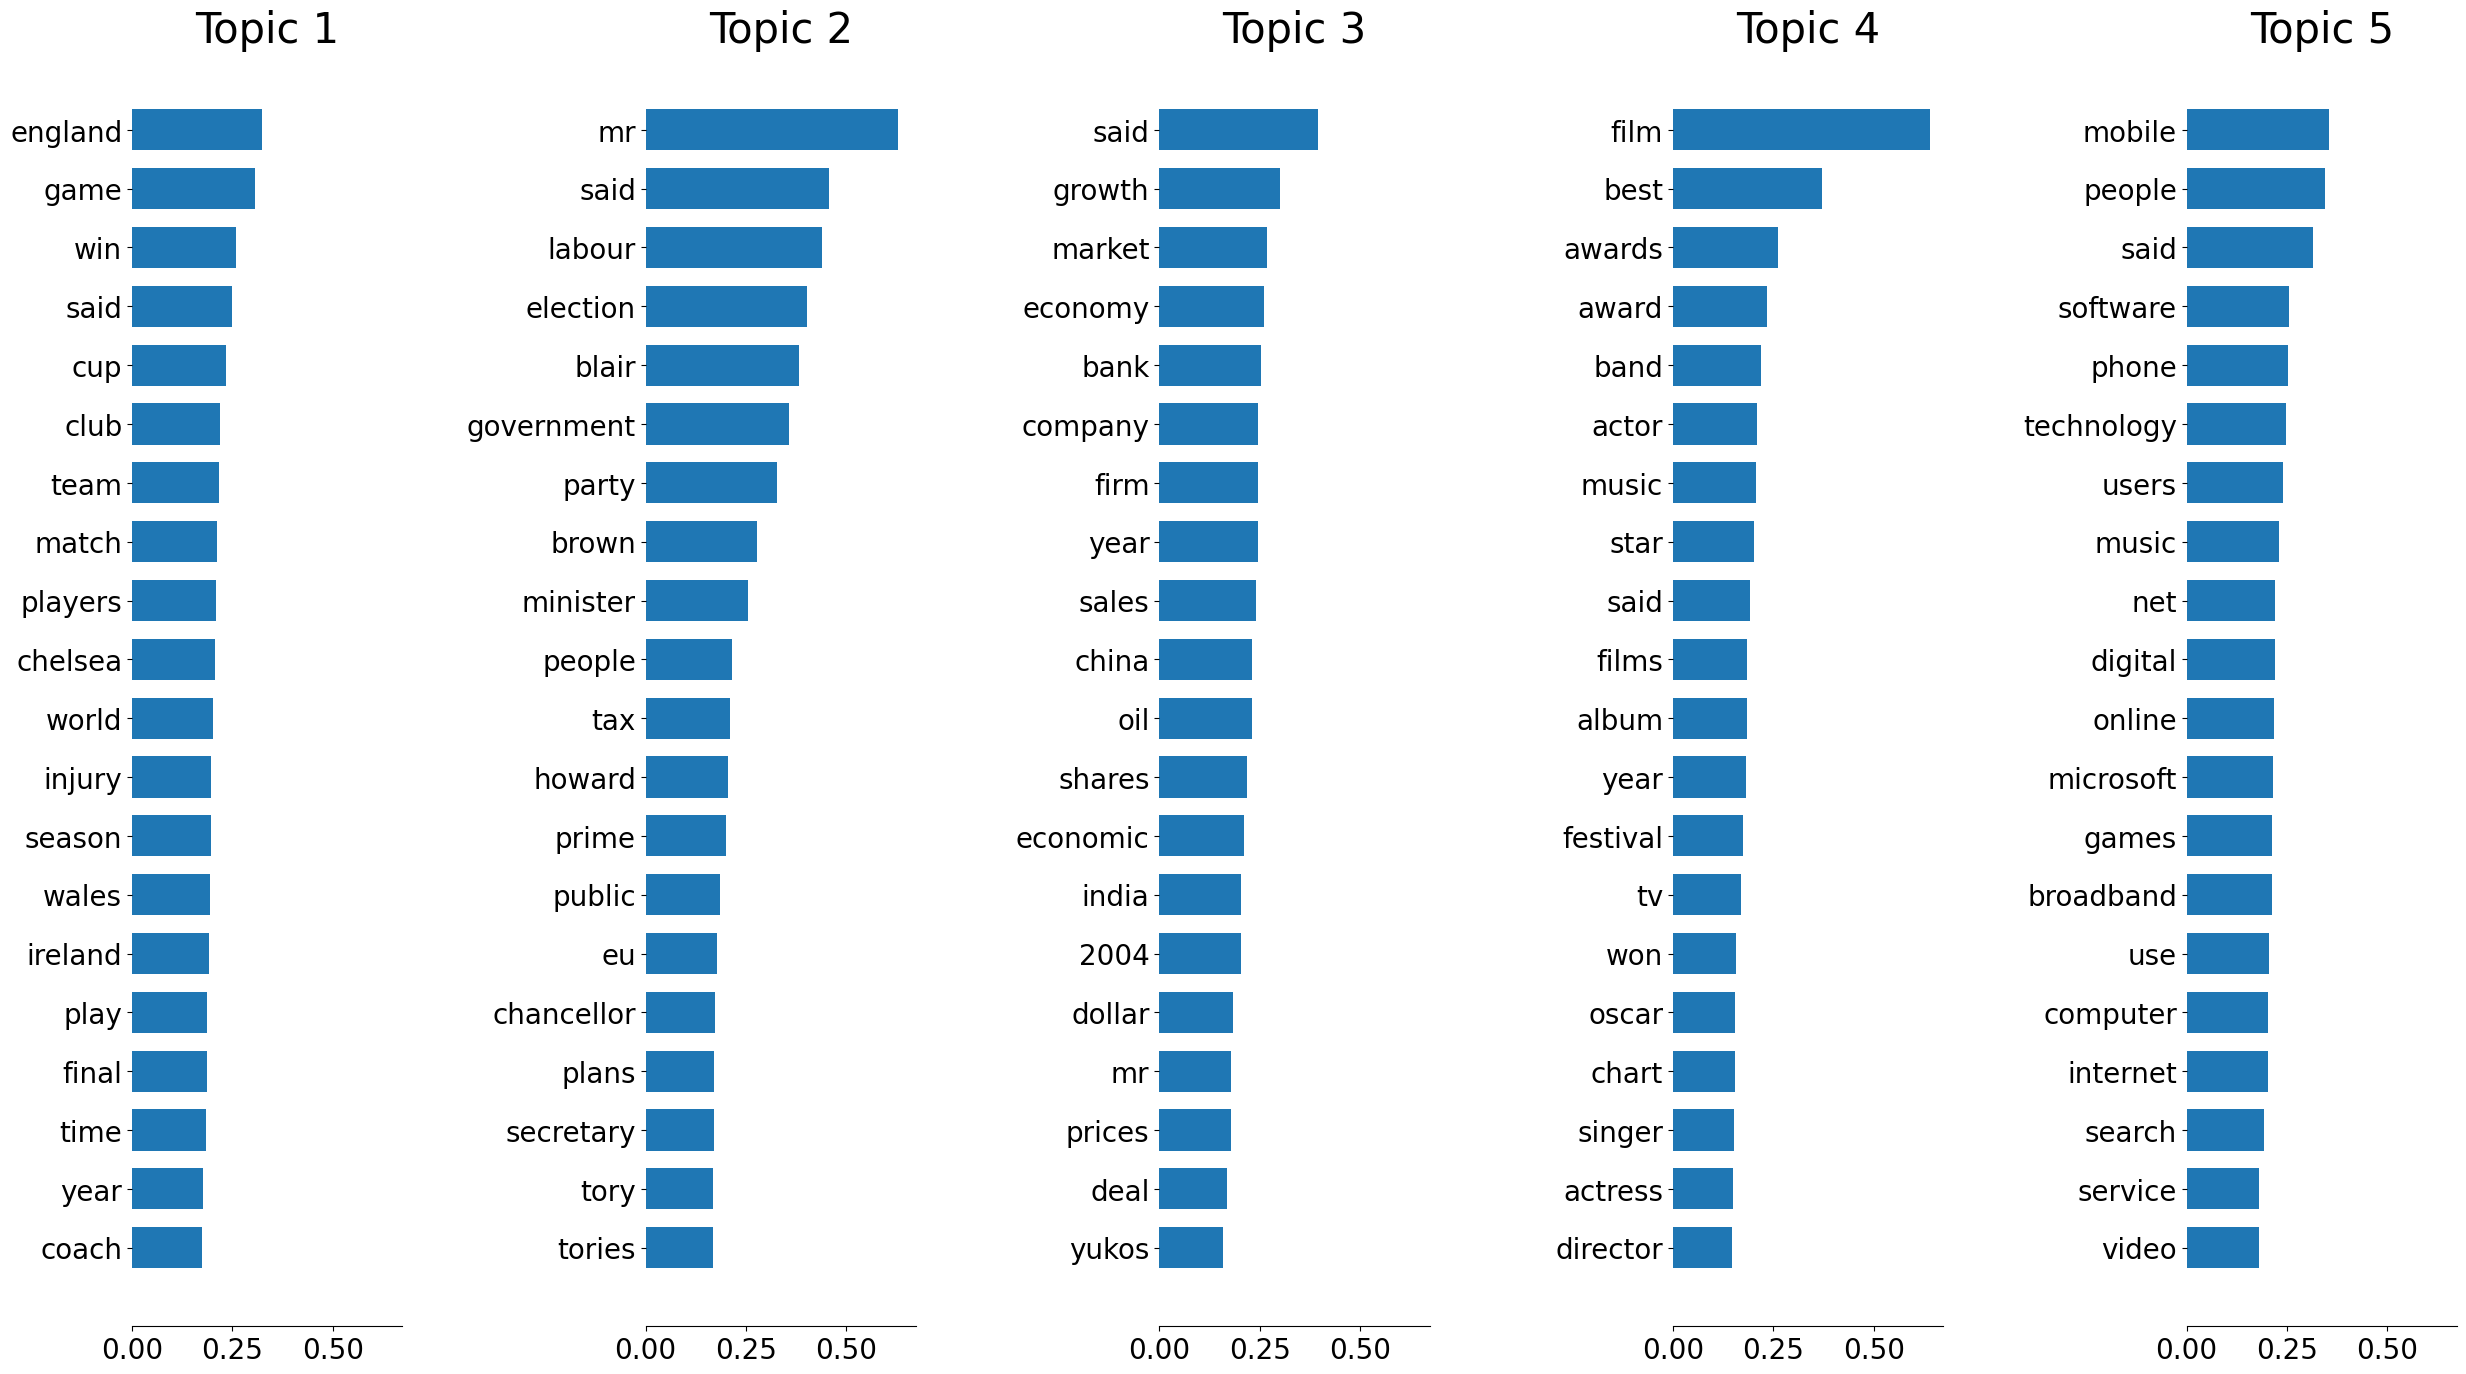

In [417]:
plot_top_words(H2, features)

Model Comparison:
* The parameters mostly were kept the same other than beta_loss and solver.
* Kullback-leibler model showed significant improvement from Frobenius model, showing that tweaking parameters do play a big role in improving the model accuracy.
* We can also see the difference in the way these two models give weights to terms by looking for the top words.

4. Supervised Learning

In this section, we will visit supervised learning method to compare the both.

In [418]:
y_train = train_data['Category']
log_reg = LogisticRegression(max_iter=1000).fit(vec_mat, y_train)

In [419]:
y_train_pred = log_reg.predict(vec_mat)
logistic_acc_score = round(accuracy_score(y_train, y_train_pred), 4)
print('Training accuracy for logistic regression: ', logistic_acc_score)

Training accuracy for logistic regression:  0.9972


In [420]:
# We will also do the prediction for test dataset
test_vec_mat = vectorizer.transform(test_data.Text)
y_test_pred = log_reg.predict(test_vec_mat)
test_data_df = test_data.copy()
test_data_df['Category'] = y_test_pred
test_data_df.head()
test_data_df = test_data_df[['ArticleId', 'Category']]
test_data_df.to_csv('submission.csv', index=False)

Comparison:
* When comparing Supervised and Unsupervised learning methods, logistic regression significantly outperforms the unsupervised learning methods.
* Supvervised learning is trained on the reduced features from NMF and evaluated on the test dataset.
* The predictions from supervised learning is exported to csv and uploaded for submission to kaggle.